In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera
import my_afml_fncs
from my_afml_fncs import getTEvents

In [3]:
volume_bars_df=pd.read_csv('./tick_data/bars/volume_bars_barchart.csv')

In [4]:
volume_bars_df.info()
volume_bars_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14244 entries, 0 to 14243
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Symbol  14244 non-null  object 
 1   Open    14244 non-null  float64
 2   High    14244 non-null  float64
 3   Low     14244 non-null  float64
 4   Close   14244 non-null  float64
 5   Volume  14244 non-null  int64  
 6   Time    14244 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 779.1+ KB


,Symbol,Open,High,Low,Close,Volume,Time
0,ESH23,3895.00,3900.00,3849.50,3849.75,50304,2023-01-02 23:00:00
1,ESH23,3849.50,3867.75,3842.75,3864.00,50044,2023-01-03 01:06:00
2,ESH23,3864.00,3888.50,3864.00,3882.75,50000,2023-01-03 05:00:00
3,ESH23,3882.75,3905.75,3882.50,3903.00,50498,2023-01-03 08:24:00
4,ESH23,3903.00,3906.75,3872.25,3877.75,50126,2023-01-03 09:45:00


In [4]:
# get the rolled series
rolled=my_afml_fncs.getRolledSeries(volume_bars_df)
rolled.index=pd.to_datetime(rolled.index)
# resample to analyse weekly and count how many bars there are per week
weekly=rolled['Close'].resample('W').count()
# calculate the autocorrelation of the returns
autocorrelation=weekly.autocorr(lag=1)

In [5]:
# calculate returns, should this be daily? no because we're seeing how sampling techniques change the dist
rolled['Returns']=rolled['Close'].pct_change()
# 2.1 (d) resample monthly by the variance of the returns and calculate the variance of those variances
monthly_variance=rolled['Returns'].resample('ME').var()
monthly_variance.var()

np.float64(5.202925021514066e-14)

In [6]:
# 2.1 (e) normality test, with n/a dropped
returns = rolled['Returns'].dropna()
jb_stat, jb_pvalue = jarque_bera(returns)
print(f"Jarque-Bera Test Statistic: {jb_stat}")
print(f"p-value: {jb_pvalue}")
# Interpretation
if jb_pvalue < 0.05:
    print("Reject the null hypothesis: Returns are not normally distributed.")
else:
    print("Fail to reject the null hypothesis: Returns are normally distributed.")

Jarque-Bera Test Statistic: 336178.0522068954
p-value: 0.0
Reject the null hypothesis: Returns are not normally distributed.


In [17]:
# 2.4 (a) create bollinger

window = 1000  # Default rolling window size
percentage_width = 0.025  # 5% width

# Step 1: Calculate the Simple Moving Average (SMA) for Close prices
rolled['SMA'] = rolled['Close'].rolling(window=window).mean()

# Step 2: Calculate the Upper and Lower Bollinger Bands with 5% width
rolled['Upper Band'] = rolled['SMA'] + (rolled['SMA'] * percentage_width)
rolled['Lower Band'] = rolled['SMA'] - (rolled['SMA'] * percentage_width)

# Step 3: Inspect the DataFrame (now contains Bollinger Bands)
print(rolled[['Close', 'SMA', 'Upper Band', 'Lower Band']].tail())


                       Close         SMA   Upper Band   Lower Band
Time                                                              
2024-12-31 20:58:00  5935.00  5995.01325  6144.888581  5845.137919
2024-12-31 21:00:00  5936.25  5994.81250  6144.682813  5844.942187
2024-12-31 21:01:00  5934.75  5994.62675  6144.492419  5844.761081
2024-12-31 21:05:00  5938.25  5994.44350  6144.304588  5844.582412
2024-12-31 21:14:00  5939.00  5994.26275  6144.119319  5844.406181


In [18]:
# count how many time prices cross the bands in to out
# Step 1: Initialize the counters for crossings
crossed_above = 0
above_index=[]
crossed_below = 0
below_index=[]

# Step 2: Iterate through the DataFrame to count crossings
for i in range(1, len(rolled)):
    # Check if Close crosses above the Upper Band
    if (rolled['Close'].iloc[i - 1] <= rolled['Upper Band'].iloc[i - 1]) and \
            (rolled['Close'].iloc[i] > rolled['Upper Band'].iloc[i]):
        crossed_above += 1
        above_index.append(i)

    # Check if Close crosses below the Lower Band
    if (rolled['Close'].iloc[i - 1] >= rolled['Lower Band'].iloc[i - 1]) and \
            (rolled['Close'].iloc[i] < rolled['Lower Band'].iloc[i]):
        crossed_below += 1
        below_index.append(i)

# Output the results
print(f"Number of times Close crossed above the Upper Band: {crossed_above}")
print(f"Number of times Close crossed below the Lower Band: {crossed_below}")

Number of times Close crossed above the Upper Band: 115
Number of times Close crossed below the Lower Band: 75


In [33]:
# 2.4 (b) Sample the bars with CUSUM filter on the returns h=0.05
# we are only sampling the bars where the band is crossed. Section 2.5 is saying we look for a 5% move after certain conditions are met e.g. band is crossed
# y(t) are the returns, so E[y(t)]=0 not y(t-1), hence in cusum function diff=gRaw.pct_change()
cross=above_index+below_index
sorted_cross=sorted(cross)
cross_df=rolled.iloc[sorted_cross]
h=0.05
# cusum_filter=getTEvents(rolled['Close'],h)
cusum_bb_filter=getTEvents(cross_df['Close'],h)
print(len(rolled['Returns']))
print(len(cusum_bb_filter))
roll_bb_cusum=rolled.loc[cusum_bb_filter]
roll_bb_cusum['Close'].rolling(window=5).std()

61564
11


2023-02-24 14:43:00           NaN
2023-03-31 20:13:00           NaN
2023-06-13 02:58:00           NaN
2023-10-23 09:43:00           NaN
2023-11-08 16:12:00    186.389998
2023-12-13 23:47:00    224.222727
2024-05-15 18:31:00    386.733557
2024-08-06 07:55:00    435.410776
2024-08-14 15:44:00    392.026649
2024-09-18 20:10:00    314.296188
2024-11-11 18:23:00    309.274079
Name: Close, dtype: float64

In [32]:
cusum_filter=getTEvents(rolled['Close'],h)
print(len(rolled['Returns']))
print(len(cusum_filter))
roll_cusum=rolled.loc[cusum_filter]
roll_cusum['Close'].rolling(window=5).std()

61564
27


2023-01-12 14:01:00           NaN
2023-01-27 20:06:00           NaN
2023-02-22 15:31:00           NaN
2023-03-10 18:16:00           NaN
2023-03-21 19:42:00     85.945295
2023-04-03 14:47:00    107.244843
2023-06-02 15:54:00    153.320192
2023-06-16 14:23:00    233.081973
2023-07-19 14:30:00    231.443203
2023-08-17 19:44:00    176.461982
2023-09-26 15:12:00    128.046207
2023-10-25 21:52:00    153.470009
2023-11-03 12:23:00    146.382995
2023-11-22 14:35:00    138.226332
2023-12-28 01:03:00    233.963499
2024-01-29 20:15:00    292.440325
2024-02-23 14:31:00    279.371135
2024-04-17 16:31:00    184.946698
2024-05-07 14:31:00    128.261281
2024-06-14 21:18:00    190.463300
2024-07-25 15:09:00    182.350401
2024-08-05 00:31:00    173.973112
2024-08-12 12:30:00    108.868126
2024-08-19 20:54:00    115.868541
2024-09-13 21:26:00    157.174803
2024-11-06 20:13:00    256.345104
2024-12-16 17:33:00    301.157403
Name: Close, dtype: float64

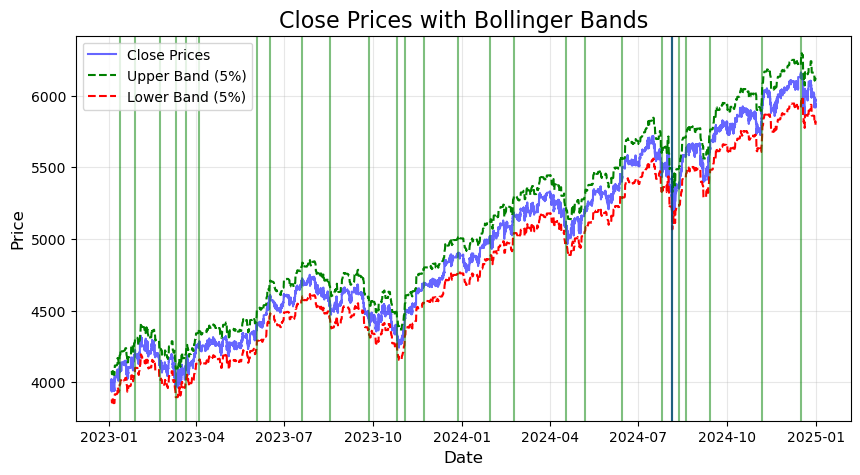

In [20]:

# Step 1: Define the figure size and style
plt.figure(figsize=(10, 5))

# Step 2: Plot Close prices
plt.plot(rolled['Close'], label='Close Prices', color='blue', alpha=0.6)

# Step 3: Plot the SMA
# plt.plot(rolled['SMA'], label='SMA (20)', color='orange', linewidth=2)

# Step 4: Plot the Upper and Lower Bollinger Bands
plt.plot(rolled['Upper Band'], label='Upper Band (5%)', color='green', linestyle='--')
plt.plot(rolled['Lower Band'], label='Lower Band (5%)', color='red', linestyle='--')



# Step 5: Add chart details
plt.title('Close Prices with Bollinger Bands', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Add vertical lines for above_index and below_index
for index in above_index:
    plt.axvline(rolled.index[index], color='red', linestyle='-', alpha=0.5, label='_nolegend_')  # Red for above

for index in below_index:
    plt.axvline(rolled.index[index], color='blue', linestyle='-', alpha=0.5, label='_nolegend_')  # Blue for below

for cusum in cusum_filter:
    plt.axvline(cusum, color='green', linestyle='-', alpha=0.5, label='_nolegend_')  # Green for cusum

# Step 6: Show the plot
plt.show()

In [10]:
dollar_bars_df=pd.read_csv('./tick_data/bars/dollar_bars_barchart.csv')

In [11]:
rolled_dollar=my_afml_fncs.getRolledSeries(dollar_bars_df)

In [12]:
rolled_dollar.index=pd.to_datetime(rolled_dollar.index)

In [13]:
weekly_dollar=rolled_dollar['Close'].resample('W').count()

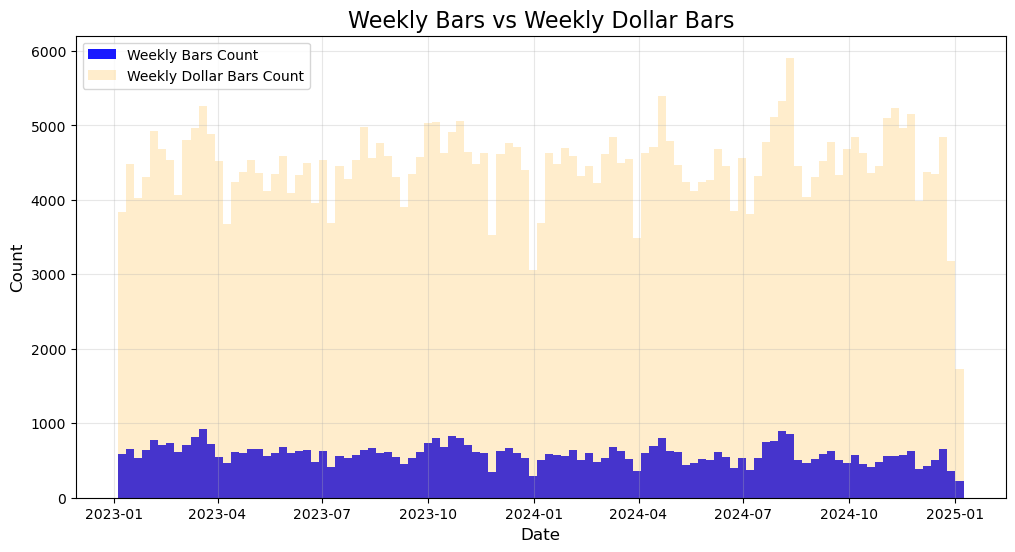

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(weekly.index, weekly, width=7, label='Weekly Bars Count', alpha=0.9, color='blue')
plt.bar(weekly_dollar.index, weekly_dollar, width=7, label='Weekly Dollar Bars Count', alpha=0.2, color='orange')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Weekly Bars vs Weekly Dollar Bars', fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()